# All-pole model prior $p(x,y)$

## Model

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this.

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

The coefficients are given by "the excluded pole product":

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p) = {G \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

where the gain $G = \prod_{k=1}^K |p_k|^2$ and $\tilde{h}(x; p)$ is defined below.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

Transfer function: (Fourier transform of $h(t; p)$ with our convention)

$$ \tilde{h}(x; p) = {G \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

Note that the overall scale is determined by the DGF, so we normalize such that $h(0, p) = 1$.



## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

### PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [1]:
%run init.ipy

from vtr.prior import bandwidth

2022-11-09 11:03:43.779548: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]4.3s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]19.5s, 0.3min   : Loading run_nested...
[Memory]21.0s, 0.4min   : Loading run_nested...
[Memory]22.5s, 0.4min   : Loading run_nested...
[Memory]24.0s, 0.4min   : Loading run_nested...
[Memory]24.0s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]27.7s, 0.5min   : Loading get_vtrformants_training_data...
[Memory]35.9s, 0.6min   : Loading run_nested...
[Memory]36.7s, 0.6min   : Loading run_nested...
[Memory]37.6s, 0.6min   : Loading run_nested...
[Memory]38.5s, 0.6min   : Loading run_nested...
[Memory]38.5s, 0.6min   : Loading get_vtrformants_training_data...


In [4]:
prior = bandwidth.TFB_prior()

[Memory]57.7s, 1.0min   : Loading get_vtrformants_training_data...
[Memory]58.1s, 1.0min   : Loading run_nested...
[Memory]58.6s, 1.0min   : Loading run_nested...


In [22]:
T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)
xy, x, y

(array([ 626.24056569, 1508.24008306, 2229.93562579,   39.60147886,
          98.6690927 ,  184.46523261]),
 array([ 626.24056569, 1508.24008306, 2229.93562579]),
 array([ 39.60147886,  98.6690927 , 184.46523261]))

[array([ 575.54819204, 1490.40183115, 2508.85172279]),
 array([52.38096893, 49.07238698, 76.88592201])]

In [30]:
from dgf import core

poles = core.make_poles(y, x)
poles

DeviceArray([-0.12441172 +3.93478552j, -0.3099781  +9.47655193j,
             -0.57951462+14.01109876j], dtype=complex128)

[ 457.80449299 1446.00442058 2756.53750204]
[42.86515346 57.92587634 82.14270853]


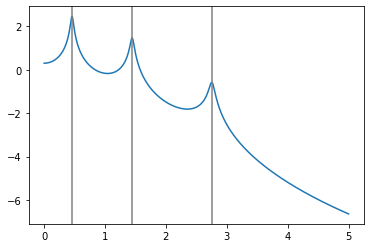

In [143]:
from lib import constants

T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

@jax.jit
def htilde_power_dB(x, poles):
    def labs(x):
        return jnp.log10(jnp.abs(x))

    s = (1j)*x*2*jnp.pi
    G = jnp.sum(2*labs(poles))
    denom = jnp.sum(labs(s - poles) + labs(s - jnp.conjugate(poles)))
    correction = labs(2.) # Include power in negative frequencies
    return 2*(G - denom) + correction

f = np.linspace(0, constants.FS_KHZ/2, 500)

h = jax.vmap(htilde_power_dB, (0, None))(f, poles)

plot(f, h)
for xi in x: axvline(xi/1000, color="grey")

OK the peak picking will not always be able to distuingish 3 peaks, because sometimes the peaks merge!!

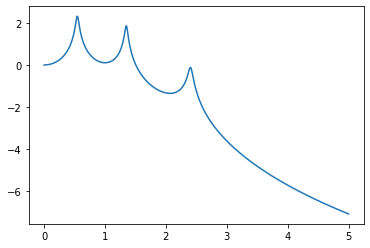

In [141]:
import scipy.signal

p = hstack([poles, conj(poles)])*1000
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f*1000)
plot(f, 2*log10(abs(H)))